In [1]:
import numpy as np
from scipy.stats import norm

class MertonModel:
    """
    Merton (1974) structural credit model.

    Parameters
    ----------
    asset_value : float
        Current total value of firm assets V0.
    debt_value : float
        Face value of debt due at maturity D (not today's market value).
    risk_free_rate : float
        Risk-free rate (annual, decimal).
    sigma_asset : float
        Asset volatility (annual, decimal).
    time_to_maturity : float
        Time to maturity in years (e.g., 1.0 for one year).
    """
    def __init__(self, asset_value, debt_value, risk_free_rate, sigma_asset, time_to_maturity):
        self.asset_value = float(asset_value)
        self.debt_face   = float(debt_value)
        self.r           = float(risk_free_rate)
        self.sigma_A     = float(sigma_asset)
        self.T           = float(time_to_maturity)

    def _d1_d2(self):
        if self.T <= 0 or self.sigma_A <= 0:
            raise ValueError("time_to_maturity and sigma_asset must be > 0")
        sigma_sqrtT = self.sigma_A * np.sqrt(self.T)
        d1 = (np.log(self.asset_value / self.debt_face) + (self.r + 0.5*self.sigma_A**2)*self.T) / sigma_sqrtT
        d2 = d1 - sigma_sqrtT
        return d1, d2

    def default_probability(self):
        """Risk-neutral probability of default at T: N(-d2)."""
        _, d2 = self._d1_d2()
        return norm.cdf(-d2)

    def equity_value(self):
        """Equity as a call on assets: E0 = V0*N(d1) - D*e^{-rT}*N(d2)."""
        d1, d2 = self._d1_d2()
        return self.asset_value*norm.cdf(d1) - self.debt_face*np.exp(-self.r*self.T)*norm.cdf(d2)

    def debt_value(self):
        """Defaultable debt value: B0 = V0 - E0."""
        return self.asset_value - self.equity_value()

    def credit_spread(self):
        """
        Flat spread s that prices debt as B0 = D * exp(-(r+s)T).
        s = - (1/T) * ln(B0 / D) - r
        """
        B0 = self.debt_value()
        return -np.log(B0 / self.debt_face) / self.T - self.r

Risk-neutral PD (T=1.0y): 37.49%
Equity value E0: 5558465216.82
Debt value  B0: 19441534783.18
Implied credit spread: 7.86 bps


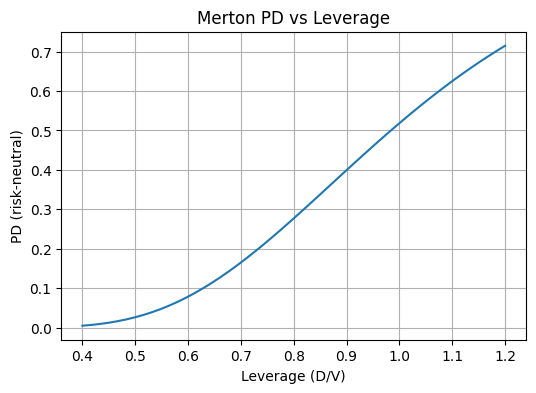

In [2]:
# Example parameters
V0 = 25000000000   # asset value
D  =   22000000000   # face debt due at T
r  = 0.045      # risk-free rate
sigma_A = 0.35 # asset vol
T  = 1.0       # years

m = MertonModel(asset_value=V0, debt_value=D, risk_free_rate=r, sigma_asset=sigma_A, time_to_maturity=T)

pd = m.default_probability()
E0 = m.equity_value()
B0 = m.debt_value()
s  = m.credit_spread()

print(f"Risk-neutral PD (T={T:.1f}y): {pd:.2%}")
print(f"Equity value E0: {E0:.2f}")
print(f"Debt value  B0: {B0:.2f}")
print(f"Implied credit spread: {s*100:.2f} bps")

# Optional: PD vs leverage (D/V) quick sketch
import numpy as np
import matplotlib.pyplot as plt

leverage = np.linspace(0.4, 1.2, 50)   # D/V range
pds = []
for L in leverage:
    mm = MertonModel(asset_value=V0, debt_value=L*V0, risk_free_rate=r, sigma_asset=sigma_A, time_to_maturity=T)
    pds.append(mm.default_probability())

plt.figure(figsize=(6,4))
plt.plot(leverage, pds)
plt.xlabel("Leverage (D/V)")
plt.ylabel("PD (risk-neutral)")
plt.title("Merton PD vs Leverage")
plt.grid(True)
plt.show()

Credit Risk Assessmet (Merton Model)
Based on inputs of 25B in assets, 22B in debt, 35% asset volatility, a 4.5% risk-free rate, and a 1-year horizon, the Merton model generates a 1-year probability of default of ~37.5%.
This output places the firm firmly in the CCC/CC distressed range compared to historical rating agency benchmarks (Moody’s 1-year default rate for CCC is ~20–30%). Such a high PD suggests imminent refinancing stress or potential restructuring risk.
Interpretation: The model highlights the firm’s thin asset coverage (assets only ~13% above debt) combined with elevated volatility, which magnifies downside scenarios. This suggests that under current capital structure and market conditions, the firm is at severe risk of default within 12 months.
Next steps for analysis:
•	Stress test lower leverage (e.g., 20B debt instead of 22B) to quantify the sensitivity of PD to capital structure.
•	Assess longer maturities (T=2) to see how PD compounds over time.
•	Compare implied PD to market signals (bond spreads, CDS levels) for validation.
